# Image Classification
In this handson you will learn how to use CNN for image classification
***This handson has used pytorch deep learning framework***
##Index
The things that are explained in this classification handson are given below.
*   Creating a custom dataset
*   Creating a neural network in PyTorch
*   Training neural network in PyTorch
*   Plotting of loss and accuracy curve
*   evaluation of performance

In [6]:
# Import libraries required in this handson
import numpy as np
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms


##Device selection
Select your device, whether you to use CPU or GPU for your model.

In [7]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)


cuda:0


##Dataset

Dataset used - Construction Material Library (CML) dataset by **RAAMAC** UIUC

Dataset link http://www.josephdegol.com/pages/MatRec_CVPR16.html

In [8]:

# Download the dataset
from google.colab import drive
!gdown --id '16aEKBpD-No2PVDo5nOJUmeBaPQ1p5vNw' --output CML_zip


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=16aEKBpD-No2PVDo5nOJUmeBaPQ1p5vNw
To: /content/CML_zip
100% 293M/293M [00:02<00:00, 99.2MB/s]


In [9]:

#unzip the data
!unzip CML_zip


Archive:  CML_zip
   creating: CML/Asphalt/
  inflating: CML/Asphalt/set_1_12_1_1.bmp  
  inflating: CML/Asphalt/set_1_12_2_1.bmp  
  inflating: CML/Asphalt/set_1_24_1_3.bmp  
  inflating: CML/Asphalt/set_1_36_1_1.bmp  
  inflating: CML/Asphalt/set_10_12_1_1.bmp  
  inflating: CML/Asphalt/set_10_12_1_10.bmp  
  inflating: CML/Asphalt/set_10_24_1_1.bmp  
  inflating: CML/Asphalt/set_10_24_1_10.bmp  
  inflating: CML/Asphalt/set_11_12_1_3.bmp  
  inflating: CML/Asphalt/set_11_12_1_7.bmp  
  inflating: CML/Asphalt/set_11_24_1_1.bmp  
  inflating: CML/Asphalt/set_11_36_1_1.bmp  
  inflating: CML/Asphalt/set_12_12_1_1.bmp  
  inflating: CML/Asphalt/set_12_12_1_8.bmp  
  inflating: CML/Asphalt/set_12_24_1_1.bmp  
  inflating: CML/Asphalt/set_12_24_1_8.bmp  
  inflating: CML/Asphalt/set_12_36_1_8.bmp  
  inflating: CML/Asphalt/set_12_36_1_9.bmp  
  inflating: CML/Asphalt/set_13_12_1_1.bmp  
  inflating: CML/Asphalt/set_13_12_1_9.bmp  
  inflating: CML/Asphalt/set_13_12_2_1.bmp  
  inflating: 

In [10]:
# Set dataset path
BASE_PATH = '/content/CML/'

classes = os.listdir(BASE_PATH)
print (classes)

['Grass', 'Concrete', 'Metal', 'Formwork', 'Soil', 'Paving', 'Asphalt', 'Marble', 'Gravel', 'Wood', 'Stone', 'Foliage', 'Brick']


In [11]:
# Convert the data into a tabular format
image=[]
labels=[]

for cls in classes:
  for folder in os.listdir(BASE_PATH):
      if folder ==cls:
          for c in os.listdir(os.path.join(BASE_PATH, folder)):
              if c!='annotations':
                  image.append(c)
                  labels.append(cls)
data = {'Images':image, 'labels':labels} 
data = pd.DataFrame(data) 
data.head()


,Images,labels
0,set_14_24_1_10.bmp,Grass
1,set_4_12_1_2.bmp,Grass
2,set_16_12_2_3.bmp,Grass
3,u_3.bmp,Grass
4,set_7_24_1_2.bmp,Grass


In [12]:
# Assign labels
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

data.to_csv("data.csv",index=False)

###Spliting of Dataset
Splitting it from sratch into training and validation set

In [13]:
batch_size = 42
validation_split = 0.2
test_split=0.1
shuffle_dataset = True
random_seed= 42

dataset_size = len(data)
indices = list(range(dataset_size))
split1 = int(np.floor(validation_split * dataset_size))
split2 = int(np.floor((validation_split+test_split) * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[split2:], indices[:split1], indices[split1:split2]

In [14]:
# Creating PyTorch data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)
#added by Tiffany

##Transforms
Transforms are common image transformations. They can be chained together using Compose.

###Normalization
Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, this transform will normalize each channel of the input torch.*Tensor i.e. input[channel] = (input[channel] - mean[channel]) / std[channel] Convert a PIL Image or numpy.ndarray to tensor.

###ToTensor
Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8

In [15]:
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
'''
train_transform = transforms.Compose(
    [transforms.RandomCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(30, resample=Image.BICUBIC, expand=False),
     transforms.GaussianBlur(7,3),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.CenterCrop(224),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.CenterCrop(224),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
#added by Tiffany

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1293: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. "


##Create custom dataset class
A dataset must contain following functions to be used by data loader later on.

*   init() function is where the initial logic happens like reading a csv, assigning transforms etc.
*   getitem() function returns the data and labels. This function is called from dataloader like this:

img, label = MyCustomDataset.getitem(99) # For 99th item


An important thing to note is that getitem() return a specific type for a single data point (like a tensor, numpy array etc.), otherwise, in the data loader you will get an error like:

TypeError: batch must contain tensors, numbers, dicts or lists; found class 'PIL.PngImagePlugin.PngImageFile'


Credits: PyTorch Custom Dataset Examples [link text](https://github.com/utkuozbulak/pytorch-custom-dataset-examples)

In [16]:
class CML_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        #image = image.convert('RGB')
        image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

train_dataset = CML_Dataset(data,BASE_PATH,train_transform)
val_dataset = CML_Dataset(data,BASE_PATH,val_transform)
test_dataset = CML_Dataset(data,BASE_PATH,test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                                sampler=test_sampler)
#added by Tiffany

In [17]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

###Visualization
visualizing the elements of the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

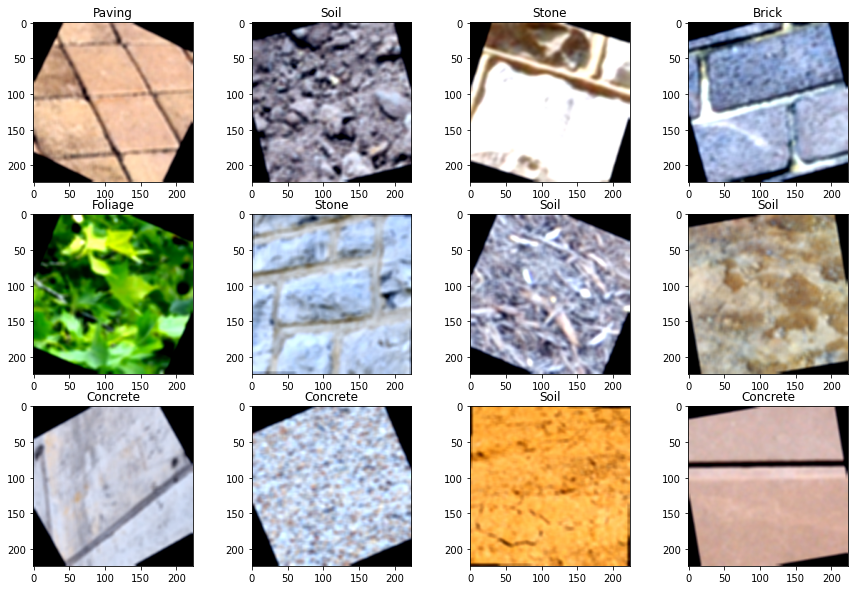

In [18]:
# get some random training images
dataiter = iter(train_loader)

images, labels = dataiter.next()
material_types = {0: 'Asphalt', 1: 'Brick', 2: 'Concrete', 3: 'Foliage', 4: 'Formwork', 5: 'Grass', 6:'Gravel', 7:'Marble', 8:'Metal', 9:'Paving', 10:'Soil', 11:'Stone', 12:'Wood'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 4, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{material_types[label.item()]}") # add label

##The Neural Network
In the **Net** class created below, we have constructed a neural network.


*   Inside the init() method you declare each layer with a unique layer name. For every unique layer, declaring its input features and output features is a must. At least the input feature is a must for some of the layers like batch normalization.
*   Inside the forward(self, x) method you need to connect the layers that were declared in the init method. One thing must be kept in mind that the output feature of one layer is an input feature of its next connecting layer.


**TIP** - If you are facing difficulty in constructing a neural network class, then I hope this tip would be very much helpful.

Keep the network summary side by side while constructing your network class in PyTorch, things would get much easier. It would be much easier to see that network summary, name the layers according to it and connect them concerning their input and output features in PyTorch.

***Example***

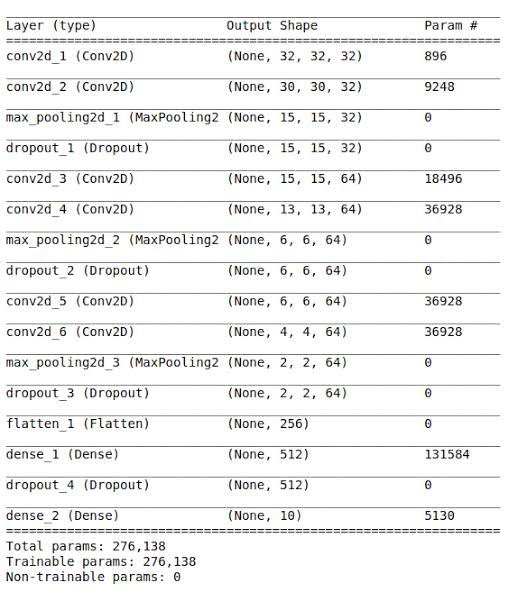

In [39]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 16 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128,kernel_size=3,stride=2, padding=1)
        self.conv5 = nn.Conv2d(128, 256,kernel_size=3,stride=2, padding=1)
        self.conv6 = nn.Conv2d(256, 512,kernel_size=3,stride=2, padding=1)
        self.conv7 = nn.Conv2d(512, 512,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.batchnorm5 = nn.BatchNorm2d(256)
        self.batchnorm6 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(64*8,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 13)

        
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.batchnorm3(self.pool(x)))
        x = self.batchnorm4(F.relu(self.conv4(x)))
        x = self.batchnorm5(F.relu(self.conv5(x)))
        x = self.batchnorm6(F.relu(self.conv6(x)))
        x = self.dropout(self.conv7(x))
        x = x.view(-1, 64*8) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = self.dropout(self.fc3(x))
        x = self.dropout(self.fc4(x))
        x = self.dropout(self.fc5(x))
        x = F.log_softmax(self.fc6(x),dim = 1)
        return x

In [40]:
model = Net().to(device)  # On GPU
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm2d(128,

###CrossEntropyLoss
It is useful when training a classification problem with C classes (more than 2 classes). If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set. In case of **Binary classification** use **BCELoss(Binary Cross Entropy)** or BCEWithLogitsLoss.

In [41]:
# Set loss criteria and choose the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [42]:
# define accuracy calculation function
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

###Training the Network
In the cell below, it is explained how to train your model with epochs. In the "train_loss" and "val_loss" the training loss and validation loss are stored respectively after every epoch. Similarly in case of training accuracy and validation accuracy also, the same thing happens. just remember while validation the weights are not upgraded thats why we use **" with torch.no_grad() ".**
Here, **"Torch.max(x, dim=1)"** works same as **"np.argmax(x, axis=1)"**. We use **".item()"** to get the value inside the tensor. **torch.save(model.state_dict(), 'model_classification_tutorial.pt')** is used to save the PyTorch weight in the given directory.

In [51]:
n_epochs = 20
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification_tutorial.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/20], Step [0/55], Loss: 1.8410
Epoch [1/20], Step [20/55], Loss: 1.3386
Epoch [1/20], Step [40/55], Loss: 1.4646

train loss: 1.6935, train acc: 43.4802
validation loss: 1.8919, validation acc: 42.5954

Detected network improvement, saving current model
Epoch 2

Epoch [2/20], Step [0/55], Loss: 2.5730
Epoch [2/20], Step [20/55], Loss: 2.4333
Epoch [2/20], Step [40/55], Loss: 2.2252

train loss: 2.0816, train acc: 21.0205
validation loss: 2.0521, validation acc: 42.4427

Epoch 3

Epoch [3/20], Step [0/55], Loss: 2.2954
Epoch [3/20], Step [20/55], Loss: 2.3800
Epoch [3/20], Step [40/55], Loss: 2.4306

train loss: 2.1876, train acc: 22.5469
validation loss: 2.0939, validation acc: 44.7328

Epoch 4

Epoch [4/20], Step [0/55], Loss: 2.3633
Epoch [4/20], Step [20/55], Loss: 2.5739
Epoch [4/20], Step [40/55], Loss: 2.4435

train loss: 2.2393, train acc: 23.8116
validation loss: 2.1169, validation acc: 40.0000

Epoch 5

Epoch [5/20], Step [0/55], Loss: 2.3683
Epoch [5/20], Step [20/55

##Accuracy and loss Curve

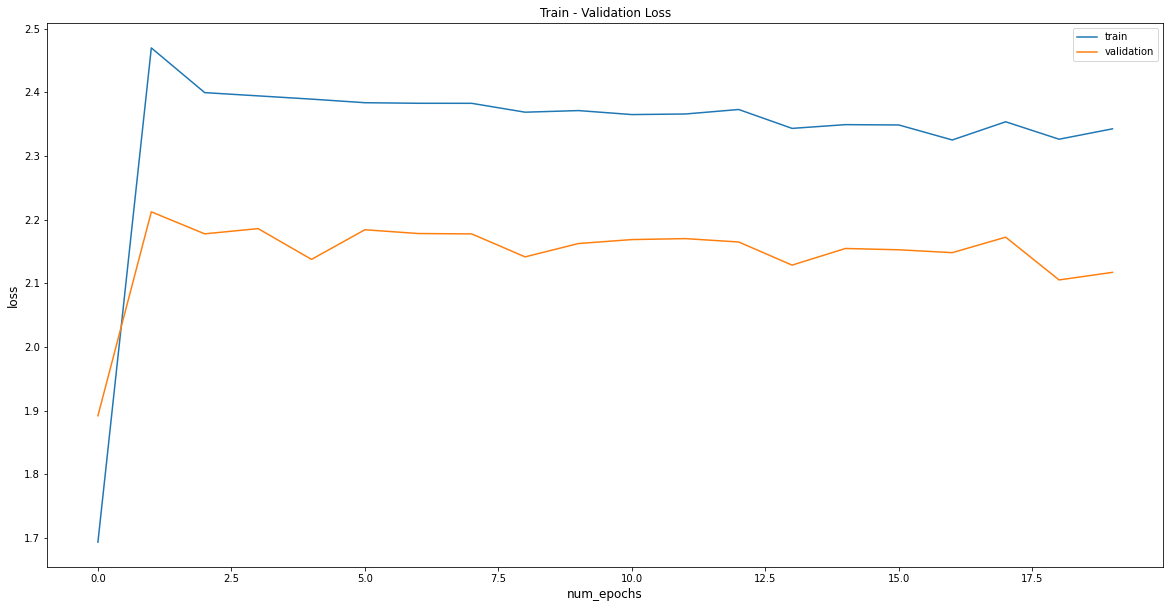

In [52]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

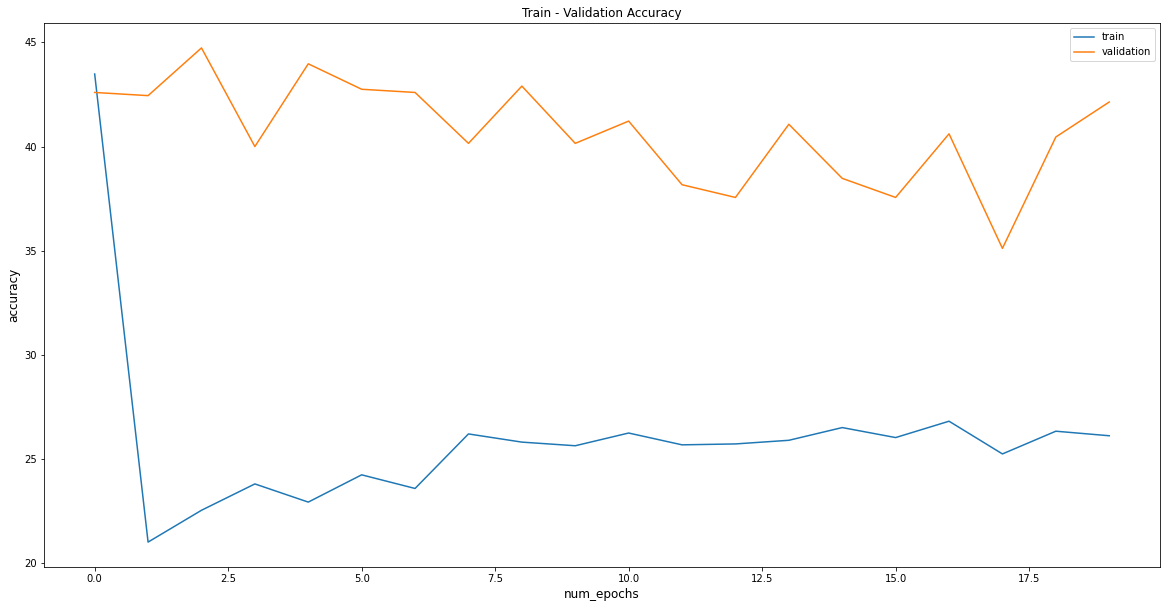

In [53]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

##Evaluation
evaluating the model performance through visualization

In [54]:
# Importing trained Network with better loss of validation
model.load_state_dict(torch.load('model_classification_tutorial.pt'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0

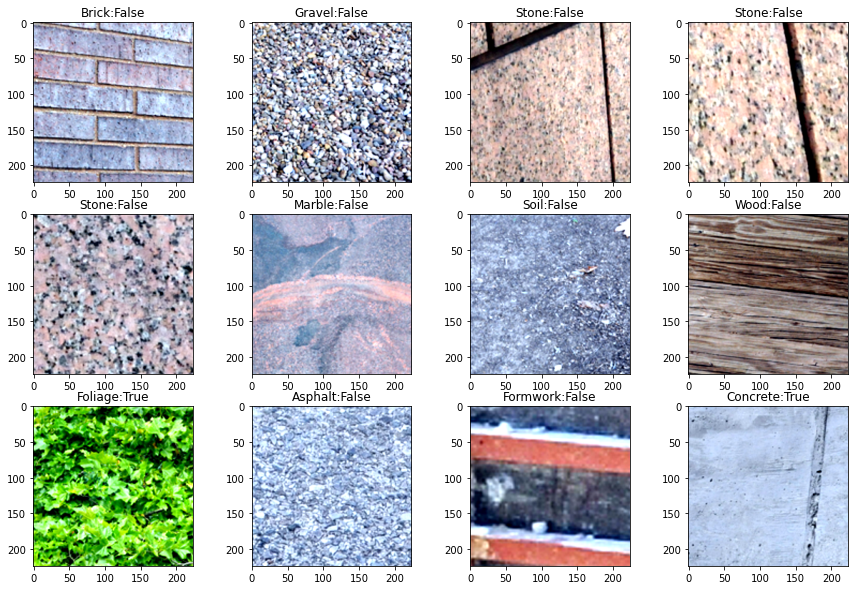

In [55]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
material_types = {0: 'Asphalt', 1: 'Brick', 2: 'Concrete', 3: 'Foliage', 4: 'Formwork', 5: 'Grass', 6:'Gravel', 7:'Marble', 8:'Metal', 9:'Paving', 10:'Soil', 11:'Stone', 12:'Wood'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 4, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0)
        output_ = model(image_tensor.to(device))
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(material_types[label.item()])+":" +str(k)) # add label

In [56]:
correct=0
total=0
for batch_idx, (data_, target_) in enumerate(test_loader):
  #print(target_)
  data_, target_ = data_.to(device), target_.to(device)# on GPU
  # zero the parameter gradients
  #optimizer.zero_grad()
  # forward + backward + optimize
  outputs = model(data_)
  _,pred = torch.max(outputs, dim=1)
  correct += torch.sum(pred==target_).item()
  total += target_.size(0)
  #print(pred)
print("Accuracy:",correct/total*100)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Accuracy: 45.25993883792049
